In [1]:
import pandas as pd
import numpy as np
import sklearn
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from sklearn.svm import SVC  
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import resample
from sklearn import svm
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import GradientBoostingClassifier
from tpot import TPOTClassifier
from sklearn.ensemble import ExtraTreesClassifier
import itertools
from sklearn.decomposition import PCA
from sklearn import datasets, linear_model
from sklearn import metrics
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression

In [2]:
model_data = pd.read_pickle('clean_added_data.pkl')

In [3]:
need_treatment = pd.read_csv('data/need_treatment.csv')

In [4]:
need_treatment['VALUE'] = need_treatment['VALUE'].fillna(need_treatment['VALUE'].mean())

In [5]:
need_treatment.head()

,STATEFP,COUNTYFP,YEAR,INDICATOR,VALUE,STATE,STATEABBREVIATION,COUNTY
0,1,1,2014,pctunmetneed,95.70,Alabama,AL,Autauga County
1,1,3,2014,pctunmetneed,91.34,Alabama,AL,Baldwin County
2,1,5,2014,pctunmetneed,91.34,Alabama,AL,Barbour County
3,1,7,2014,pctunmetneed,91.86,Alabama,AL,Bibb County
4,1,9,2014,pctunmetneed,91.86,Alabama,AL,Blount County


In [6]:
policy = pd.read_csv('data/policy.csv')

In [7]:
policy.head()

,Jurisdiction,1. Has the jurisdiction adopted opioid prescribing guidelines for acute or emergency care?,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6
0,Alabama,\nYes,NaN,NaN,NaN,NaN,NaN
1,Alaska,\nYes,NaN,NaN,NaN,NaN,NaN
2,Arizona,\nYes,NaN,NaN,NaN,NaN,NaN
3,Arkansas,\nYes,NaN,NaN,NaN,NaN,NaN
4,California,\nYes,NaN,NaN,NaN,NaN,NaN


In [8]:
policy.columns = ['state', 'policy', '1', '2', '3', '4', '5']

In [9]:
policy = policy[['state', 'policy']]

In [10]:
policy['policy'] = policy['policy'].apply(lambda x: x[1:] if x[0]=='\n' else x)

In [11]:
policy.head()

,state,policy
0,Alabama,Yes
1,Alaska,Yes
2,Arizona,Yes
3,Arkansas,Yes
4,California,Yes


In [12]:
need_treatment = need_treatment.merge(policy, left_on='STATE', right_on='state')

In [13]:
need_treatment.head()

,STATEFP,COUNTYFP,YEAR,INDICATOR,VALUE,STATE,STATEABBREVIATION,COUNTY,state,policy
0,1,1,2014,pctunmetneed,95.70,Alabama,AL,Autauga County,Alabama,Yes
1,1,3,2014,pctunmetneed,91.34,Alabama,AL,Baldwin County,Alabama,Yes
2,1,5,2014,pctunmetneed,91.34,Alabama,AL,Barbour County,Alabama,Yes
3,1,7,2014,pctunmetneed,91.86,Alabama,AL,Bibb County,Alabama,Yes
4,1,9,2014,pctunmetneed,91.86,Alabama,AL,Blount County,Alabama,Yes


In [14]:
need_treatment['county_state'] = need_treatment['COUNTY'] + ', ' + need_treatment['STATEABBREVIATION']

In [15]:
model_data = model_data.merge(need_treatment, on='county_state')

In [16]:
model_data = model_data.drop(['STATEFP', 'COUNTYFP', 'YEAR', 'INDICATOR', 'STATE', 'STATEABBREVIATION', 'COUNTY'], axis=1)

In [17]:
model_data['yoy_change_uninsured'] = model_data['uninsured_2016'] - model_data['uninsured_2015'] / model_data['uninsured_2015']

model_data['prop Under 30'] = model_data['Under 30'] / model_data['population_estimate']
model_data['30 to 44'] = model_data['30 to 44'] / model_data['population_estimate']
model_data['45 to 64'] = model_data['45 to 64'] / model_data['population_estimate']
model_data['65 and over'] = model_data['65 and over'] / model_data['population_estimate']
model_data['above 20 under 75'] = (model_data['Employment/Population Ratio; Estimate; AGE - 20 to 24 years'] + model_data['Employment/Population Ratio; Estimate; AGE - 25 to 29 years'] + model_data['Employment/Population Ratio; Estimate; AGE - 30 to 34 years'] + model_data['Employment/Population Ratio; Estimate; AGE - 35 to 44 years'] + model_data['Employment/Population Ratio; Estimate; AGE - 45 to 54 years'] + model_data['Employment/Population Ratio; Estimate; AGE - 55 to 59 years'] + model_data['Employment/Population Ratio; Estimate; AGE - 60 to 64 years'] + model_data['Employment/Population Ratio; Estimate; AGE - 65 to 74 years'])/ 8

model_data = model_data.drop(['uninsured_2017', 'prop Under 30', '30 to 44', '45 to 64', '65 and over', 'pop_white','pop_black', 'pop_native_american','pop_asian', 'pop_pac_islander','pop_ohter race','pop_two_more_races', 'county_state', 'Employment/Population Ratio; Estimate; AGE - 20 to 24 years', 'Employment/Population Ratio; Estimate; AGE - 20 to 24 years', 'Employment/Population Ratio; Estimate; AGE - 25 to 29 years', 'Employment/Population Ratio; Estimate; AGE - 30 to 34 years', 'Employment/Population Ratio; Estimate; AGE - 35 to 44 years', 'Employment/Population Ratio; Estimate; AGE - 45 to 54 years', 'Employment/Population Ratio; Estimate; AGE - 55 to 59 years', 'Employment/Population Ratio; Estimate; AGE - 60 to 64 years'], axis=1)






In [18]:
model_data.shape

(2517, 56)

In [19]:
model_data.isna().sum()

rate_avg                                                               0
prescriptions_per_100                                                  0
uninsured_2015                                                         0
uninsured_2016                                                         0
population_estimate                                                    0
median age                                                             0
Employment/Population Ratio; Estimate; AGE - 16 to 19 years            0
Employment/Population Ratio; Estimate; AGE - 65 to 74 years            0
Employment/Population Ratio; Estimate; AGE - 75 years and over         0
Percent households receiving food stamps/SNAP; Estimate; Households    0
percent_in_labor_force                                                 0
percent_in_civilian_labor_force                                        0
percent_in_civilian_labor_force_employed                               0
percent_in_civilian_labor_force_unemployed         

In [20]:
#split into X and y and scale X 
X = model_data.drop(['rate_avg'], axis=1)
y = model_data.rate_avg

X = pd.get_dummies(X)

cols = X.columns.tolist()
scaler = preprocessing.StandardScaler()
X = scaler.fit_transform(X)
X = pd.DataFrame(X, columns=cols)

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


## Testing Models

###### Model Functions

In [7]:
def log_reg(X_train, X_test, y_train, y_test): 
    logreg = LogisticRegression(fit_intercept = False, C = 1e12) 

    model_log = logreg.fit(X_train, y_train)
    model_log
    y_hat_test = logreg.predict(X_test)
    y_hat_train = logreg.predict(X_train)
    residuals = y_train - y_hat_train
    print(pd.Series(residuals).value_counts())
    print(pd.Series(residuals).value_counts(normalize=True))

    residuals = y_test - y_hat_test
    print(pd.Series(residuals).value_counts())
    print(pd.Series(residuals).value_counts(normalize=True))

In [8]:
def rf_gs(X_train, X_test, y_train, y_test):
    # Construct pipeline
    pipe_rf = Pipeline([('clf', RandomForestClassifier(random_state = 123))])

    # Set grid search params
    param_grid_forest = [ 
      {'clf__n_estimators': [100, 120],
       'clf__criterion': ['entropy', 'gini'], 
       'clf__max_depth': [4, 5, 6],  
       'clf__min_samples_leaf':[0.05 ,0.1, 0.2, 1, 2],  
       'clf__min_samples_split':[0.05 ,0.1, 0.2, 1.0, 2]
      }
    ]

    # Construct grid search
    gs_rf = GridSearchCV(estimator=pipe_rf,
                param_grid=param_grid_forest,
                scoring='accuracy',
                cv=3, verbose=2, return_train_score = True)

    # Fit using grid search
    gs_rf.fit(X_train, y_train)

    # Best accuracy
    print('Best accuracy: %.3f' % gs_rf.best_score_)

    # Best params
    print('\nBest params:\n', gs_rf.best_params_)

In [9]:
def knn_gs(X_train, X_test, y_train, y_test):
    # Construct pipeline
    pipe_knn = Pipeline([('clf', KNeighborsClassifier())])

    # Set grid search params
    knn_param_grid = {
        'clf__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8]
    }


    # Construct grid search
    gs_knn = GridSearchCV(estimator=pipe_knn,
                param_grid=knn_param_grid,
                scoring='accuracy',
                cv=3, verbose=2, return_train_score = True)

    # Fit using grid search
    gs_knn.fit(X_train, y_train)

    # Best accuracy
    print('Best accuracy: %.3f' % gs_knn.best_score_)

    # Best params
    print('\nBest params:\n', gs_knn.best_params_)

In [10]:
def svm_gs(X_train, X_test, y_train, y_test):
    # Construct pipeline
    pipe_svm = Pipeline([('clf', svm.SVC(random_state=123))])

    # Set grid search params
    param_grid_svm = [
    #  {'clf__C': [0.1, 1, 10]  , 'clf__kernel': ['linear']},
      {'clf__C': [0.1, 1, 10], 'clf__gamma': [0.001, 0.01], 'clf__kernel': ['rbf', 'linear']},
     ]

    # Construct grid search
    gs_svm = GridSearchCV(estimator=pipe_svm,
                param_grid=param_grid_svm,
                scoring='accuracy',
                cv=3, verbose=2, return_train_score = True)

    # Fit using grid search
    gs_svm.fit(X_train, y_train)

    # Best accuracy
    print('Best accuracy: %.3f' % gs_svm.best_score_)

    # Best params
    print('\nBest params:\n', gs_svm.best_params_)

In [11]:
def adaboost_gs(X_train, X_test, y_train, y_test):
    adaboost_clf = AdaBoostClassifier()

    adaboost_clf.fit(X_train, y_train)
    adaboost_train_preds = adaboost_clf.predict(X_train)
    adaboost_test_preds = adaboost_clf.predict(X_test)

    adaboost_train_score = accuracy_score(y_train, adaboost_train_preds)
    adaboost_test_score = accuracy_score(y_test, adaboost_test_preds)

    print('AdaBoosting')
    print("Training Accuracy: {:.4} \t\t Testing Accuracy: {:.4}".format(adaboost_train_score, adaboost_test_score))
    print("F1 Score: {}".format(f1_score(y_test, adaboost_test_preds, average='micro')))

In [12]:
def gb_gs(X_train, X_test, y_train, y_test):
    gb_clf = GradientBoostingClassifier(learning_rate=0.01, max_depth=6, max_features=0.2, min_samples_leaf=3, min_samples_split=15, n_estimators=100, subsample=0.25)

    gb_clf.fit(X_train, y_train)
    gb_train_preds = gb_clf.predict(X_train)
    gb_test_preds = gb_clf.predict(X_test)

    gb_train_score = accuracy_score(y_train, gb_train_preds)
    gb_test_score = accuracy_score(y_test, gb_test_preds)

    print('Gradient Boosting')
    print("Training Accuracy: {:.4} \t\t Testing Accuracy: {:.4}".format(gb_train_score, gb_test_score))
    print("F1 Score: {}".format(f1_score(y_test, gb_test_preds, average='micro')))

In [13]:
def print_metrics(labels, preds):
    print("Precision Score: {}".format(precision_score(labels, preds)))
    print("Recall Score: {}".format(recall_score(labels, preds)))
    print("Accuracy Score: {}".format(accuracy_score(labels, preds)))
    print("F1 Score: {}".format(f1_score(labels, preds)))

In [14]:
def show_cf(y_true, y_pred, class_names=None, model_name=None):
    cf = confusion_matrix(y_true, y_pred)
    plt.imshow(cf, cmap=plt.cm.Blues)
    
    if model_name:
        plt.title("Confusion Matrix: {}".format(model_name))
    else:
        plt.title("Confusion Matrix")
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    
    class_names = set(y_true)
    tick_marks = np.arange(len(class_names))
    if class_names:
        plt.xticks(tick_marks, class_names)
        plt.yticks(tick_marks, class_names)
    
    thresh = cf.max() / 2.
    
    for i, j in itertools.product(range(cf.shape[0]), range(cf.shape[1])):
        plt.text(j, i, cf[i, j], horizontalalignment='center', color='white' if cf[i, j] > thresh else 'black')

    plt.colorbar()

###### No Resampling

Best model: SVM 

Best accuracy: 0.817 

Best params: 
 {'clf__C': 1, 'clf__gamma': 0.01, 'clf__kernel': 'rbf'}

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [16]:
log_reg(X_train, X_test, y_train, y_test)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


 0    1465
 1     347
-1      75
Name: rate_avg, dtype: int64
 0    0.776365
 1    0.183890
-1    0.039746
Name: rate_avg, dtype: float64
 0    449
 1    141
-1     40
Name: rate_avg, dtype: int64
 0    0.712698
 1    0.223810
-1    0.063492
Name: rate_avg, dtype: float64


In [17]:
rf_gs(X_train, X_test, y_train, y_test)

Fitting 3 folds for each of 300 candidates, totalling 900 fits
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=100 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=100, total=   0.3s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=100 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=100, total=   0.4s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=100, total=   0.3s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.4s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.4s
[CV] clf__criterion=entropy, clf__max_depth=4, clf_

[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_sa

[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.4s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.4s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.1, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.1, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samp

[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=1, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.5s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=1, clf__min_samples_split=0.1, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=1, clf__min_samples_split=0.1, clf__n_estimators=100, total=   0.4s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=1, clf__min_samples_split=0.1, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=1, clf__min_samples_split=0.1, clf__n_estimators=100, total=   0.4s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=1, clf__min_samples_split=0.1, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=1, clf__min_samples_split=0.1, clf__n_estimators=100, total=   0.4s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=1, clf__m

[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=2, clf__min_samples_split=0.1, clf__n_estimators=100, total=   0.4s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=2, clf__min_samples_split=0.1, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=2, clf__min_samples_split=0.1, clf__n_estimators=100, total=   0.4s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=2, clf__min_samples_split=0.1, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=2, clf__min_samples_split=0.1, clf__n_estimators=120, total=   0.4s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=2, clf__min_samples_split=0.1, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=2, clf__min_samples_split=0.1, clf__n_estimators=120, total=   0.4s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=2, clf__mi

[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=120, total=   0.4s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=120, total=   0.4s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.2, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.2, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_sa

[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=100, total=   0.3s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=100, total=   0.3s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_l

[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.1, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_l

[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=1, clf__min_samples_split=0.2, clf__n_estimators=100, total=   0.3s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=1, clf__min_samples_split=0.2, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=1, clf__min_samples_split=0.2, clf__n_estimators=100, total=   0.3s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=1, clf__min_samples_split=0.2, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=1, clf__min_samples_split=0.2, clf__n_estimators=120, total=   0.4s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=1, clf__min_samples_split=0.2, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=1, clf__min_samples_split=0.2, clf__n_estimators=120, total=   0.4s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=1, clf__mi

[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=2, clf__min_samples_split=0.2, clf__n_estimators=120, total=   0.4s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=2, clf__min_samples_split=0.2, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=2, clf__min_samples_split=0.2, clf__n_estimators=120, total=   0.4s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=2, clf__min_samples_split=0.2, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=2, clf__min_samples_split=0.2, clf__n_estimators=120, total=   0.4s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=2, clf__min_samples_split=1.0, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=2, clf__min_samples_split=1.0, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=2, clf__mi

[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=0.2, clf__n_estimators=120, total=   0.4s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=1.0, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=1.0, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=1.0, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=1.0, clf__n_estimators=100, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=1.0, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=1.0, clf__n_estimators=100, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_sa

[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=1.0, clf__n_estimators=100, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=1.0, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=1.0, clf__n_estimators=100, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=1.0, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=1.0, clf__n_estimators=120, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=1.0, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=1.0, clf__n_estimators=120, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_l

[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=1.0, clf__n_estimators=120, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=1.0, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=1.0, clf__n_estimators=120, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=1.0, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=1.0, clf__n_estimators=120, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=2, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=2, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=

[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=1, clf__min_samples_split=1.0, clf__n_estimators=120, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=100, total=   0.5s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=100, total=   0.6s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=100, total=   0.5s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=1, clf__min_samples_sp

[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=100, total=   0.5s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=100, total=   0.5s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=120, total=   0.6s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=120, total=   0.6s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=2, clf__min_samples_spli

[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=2, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=2, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=2, clf__n_estimators=120, total=   0.4s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=2, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=2, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_s

[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=2, clf__n_estimators=120, total=   0.4s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=100, total=   0.4s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_sa

[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=1, clf__min_samples_split=0.05, clf__n_estimators=100, total=   0.3s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=1, clf__min_samples_split=0.05, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=1, clf__min_samples_split=0.05, clf__n_estimators=100, total=   0.3s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=1, clf__min_samples_split=0.05, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=1, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=1, clf__min_samples_split=0.05, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=1, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.4s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=1, clf__min_samples_split=0

[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=2, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=2, clf__min_samples_split=0.05, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=2, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=2, clf__min_samples_split=0.1, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=2, clf__min_samples_split=0.1, clf__n_estimators=100, total=   0.3s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=2, clf__min_samples_split=0.1, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=2, clf__min_samples_split=0.1, clf__n_estimators=100, total=   0.4s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=2, clf__min_samples_split=0.1, 

[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=100, total=   0.3s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=100, total=   0.3s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__mi

[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_sample

[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.1, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=100, total=   0.1s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_sample

[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=1, clf__min_samples_split=0.2, clf__n_estimators=100, total=   0.3s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=1, clf__min_samples_split=0.2, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=1, clf__min_samples_split=0.2, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=1, clf__min_samples_split=0.2, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=1, clf__min_samples_split=0.2, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=1, clf__min_samples_split=0.2, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=1, clf__min_samples_split=0.2, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=1, clf__min_samples_split=0.2, clf

[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=2, clf__min_samples_split=0.2, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=2, clf__min_samples_split=0.2, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=2, clf__min_samples_split=0.2, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=2, clf__min_samples_split=1.0, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=2, clf__min_samples_split=1.0, clf__n_estimators=100, total=   0.1s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=2, clf__min_samples_split=1.0, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=2, clf__min_samples_split=1.0, clf__n_estimators=100, total=   0.1s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=2, clf__min_samples_split=1.0, clf

[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=1.0, clf__n_estimators=100, total=   0.1s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=1.0, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=1.0, clf__n_estimators=100, total=   0.1s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=1.0, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=1.0, clf__n_estimators=120, total=   0.1s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=1.0, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=1.0, clf__n_estimators=120, total=   0.1s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__mi

[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=1.0, clf__n_estimators=120, total=   0.1s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=1.0, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=1.0, clf__n_estimators=120, total=   0.1s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=1.0, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=1.0, clf__n_estimators=120, total=   0.1s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=2, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=2, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_sp

[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=1.0, clf__n_estimators=120, total=   0.1s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=2, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=2, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=2, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=2, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=2, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=2, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=2, c

[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=100, total=   0.4s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=120, total=   0.5s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=120, total=   0.5s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=120, total=   0.5s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=2, clf__min_samples_split=0.05, clf__n_estimator

[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=120, total=   0.5s


[Parallel(n_jobs=1)]: Done 900 out of 900 | elapsed:  4.5min finished


Best accuracy: 0.809

Best params:
 {'clf__criterion': 'gini', 'clf__max_depth': 6, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2, 'clf__n_estimators': 100}


In [18]:
knn_gs(X_train, X_test, y_train, y_test)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] clf__n_neighbors=1 ..............................................
[CV] ............................... clf__n_neighbors=1, total=   0.1s
[CV] clf__n_neighbors=1 ..............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] ............................... clf__n_neighbors=1, total=   0.1s
[CV] clf__n_neighbors=1 ..............................................
[CV] ............................... clf__n_neighbors=1, total=   0.1s
[CV] clf__n_neighbors=2 ..............................................
[CV] ............................... clf__n_neighbors=2, total=   0.1s
[CV] clf__n_neighbors=2 ..............................................
[CV] ............................... clf__n_neighbors=2, total=   0.1s
[CV] clf__n_neighbors=2 ..............................................
[CV] ............................... clf__n_neighbors=2, total=   0.1s
[CV] clf__n_neighbors=3 ..............................................
[CV] ............................... clf__n_neighbors=3, total=   0.1s
[CV] clf__n_neighbors=3 ..............................................
[CV] ............................... clf__n_neighbors=3, total=   0.1s
[CV] clf__n_neighbors=3 ..............................................
[CV] .

[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:    7.7s finished


In [19]:
svm_gs(X_train, X_test, y_train, y_test)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] clf__C=0.1, clf__gamma=0.001, clf__kernel=rbf ...................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .... clf__C=0.1, clf__gamma=0.001, clf__kernel=rbf, total=   0.2s
[CV] clf__C=0.1, clf__gamma=0.001, clf__kernel=rbf ...................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV] .... clf__C=0.1, clf__gamma=0.001, clf__kernel=rbf, total=   0.1s
[CV] clf__C=0.1, clf__gamma=0.001, clf__kernel=rbf ...................
[CV] .... clf__C=0.1, clf__gamma=0.001, clf__kernel=rbf, total=   0.1s
[CV] clf__C=0.1, clf__gamma=0.001, clf__kernel=linear ................
[CV] . clf__C=0.1, clf__gamma=0.001, clf__kernel=linear, total=   0.1s
[CV] clf__C=0.1, clf__gamma=0.001, clf__kernel=linear ................
[CV] . clf__C=0.1, clf__gamma=0.001, clf__kernel=linear, total=   0.2s
[CV] clf__C=0.1, clf__gamma=0.001, clf__kernel=linear ................
[CV] . clf__C=0.1, clf__gamma=0.001, clf__kernel=linear, total=   0.1s
[CV] clf__C=0.1, clf__gamma=0.01, clf__kernel=rbf ....................
[CV] ..... clf__C=0.1, clf__gamma=0.01, clf__kernel=rbf, total=   0.1s
[CV] clf__C=0.1, clf__gamma=0.01, clf__kernel=rbf ....................
[CV] ..... clf__C=0.1, clf__gamma=0.01, clf__kernel=rbf, total=   0.2s
[CV] clf__C=0.1, clf__gamma=0.01, clf__kernel=rbf ....................
[CV] .

[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:   20.7s finished


In [40]:
# adaboost_gs(X_train, X_test, y_train, y_test)

In [23]:
gb_gs(X_train, X_test, y_train, y_test)

Gradient Boosting
Training Accuracy: 0.8256 		 Testing Accuracy: 0.7778
F1 Score: 0.7777777777777778


###### Downsampling

Best model: SVM 
    
Best accuracy: 0.796

Best params:
 {'clf__C': 1, 'clf__gamma': 0.01, 'clf__kernel': 'rbf'}

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

y_train_df = y_train.to_frame()

df_train = pd.concat([X_train, y_train_df], axis=1)

df_majority = df_train[df_train.rate_avg==1]
df_minority = df_train[df_train.rate_avg==0]

df_majority_downsampled = resample(df_majority, 
                                 replace=False,    
                                 n_samples=513,  
                                 random_state=123)

df_downsampled = pd.concat([df_majority_downsampled, df_minority])

X_train = df_downsampled.drop(['rate_avg'], axis=1)
y_train = df_downsampled.rate_avg

In [25]:
log_reg(X_train, X_test, y_train, y_test)

 0    837
 1    128
-1     61
Name: rate_avg, dtype: int64
 0    0.815789
 1    0.124756
-1    0.059454
Name: rate_avg, dtype: float64
 0    446
 1    144
-1     40
Name: rate_avg, dtype: int64
 0    0.707937
 1    0.228571
-1    0.063492
Name: rate_avg, dtype: float64


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [26]:
rf_gs(X_train, X_test, y_train, y_test)

Fitting 3 folds for each of 300 candidates, totalling 900 fits
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=100 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=100, total=   0.3s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=100 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=entropy, clf__max_depth=4, clf_

[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samp

[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.1, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.1, clf__n_estimators=100, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.1, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.1, clf__n_estimators=100, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.1, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.1, clf__n_estimators=100, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_

[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=1, clf__min_samples_split=0.1, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=1, clf__min_samples_split=0.1, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=1, clf__min_samples_split=0.1, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=1, clf__min_samples_split=0.1, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=1, clf__min_samples_split=0.1, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=1, clf__min_samples_split=0.1, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=1, clf__min_samples_split=0.1, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=1, clf__mi

[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=2, clf__min_samples_split=0.1, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=2, clf__min_samples_split=0.1, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=2, clf__min_samples_split=0.1, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=2, clf__min_samples_split=0.1, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=2, clf__min_samples_split=0.1, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=2, clf__min_samples_split=0.2, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=2, clf__min_samples_split=0.2, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=2, clf__mi

[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.2, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.2, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.2, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.2, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.2, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.2, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_sa

[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_l

[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=100, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=120, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=120, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_l

[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=1, clf__min_samples_split=0.2, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=1, clf__min_samples_split=0.2, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=1, clf__min_samples_split=0.2, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=1, clf__min_samples_split=1.0, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=1, clf__min_samples_split=1.0, clf__n_estimators=100, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=1, clf__min_samples_split=1.0, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=1, clf__min_samples_split=1.0, clf__n_estimators=100, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=1, clf__mi

[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=2, clf__min_samples_split=1.0, clf__n_estimators=100, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=2, clf__min_samples_split=1.0, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=2, clf__min_samples_split=1.0, clf__n_estimators=120, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=2, clf__min_samples_split=1.0, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=2, clf__min_samples_split=1.0, clf__n_estimators=120, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=2, clf__min_samples_split=1.0, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=2, clf__min_samples_split=1.0, clf__n_estimators=120, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=2, clf__mi

[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=1.0, clf__n_estimators=120, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=1.0, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=1.0, clf__n_estimators=120, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=2, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=2, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=2, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=2, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_le

[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=2, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=2, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=2, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=2, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=2, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=2, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=2, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__

[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=2, clf__n_estimators=100, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=2, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=2, clf__n_estimators=100, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=2, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=2, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=2, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=2, clf__n_estimators=120, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__

[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=120, total=   0.4s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=120, total=   0.4s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=120, total=   0.4s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=2, clf__min_samples_split=0.05, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=2, clf__min_samples_split=0.05, clf__n_estimators=100, total=   0.3s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=2, clf__min_sample

[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.05, clf

[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=100, total=   0.1s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min

[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.1s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.1, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.1, clf__n_estimators=100, total=   0.1s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_s

[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=1, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=1, clf__min_samples_split=0.1, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=1, clf__min_samples_split=0.1, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=1, clf__min_samples_split=0.1, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=1, clf__min_samples_split=0.1, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=1, clf__min_samples_split=0.1, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=1, clf__min_samples_split=0.1, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=1, clf__min_samples_split=0.1, cl

[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=2, clf__min_samples_split=0.1, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=2, clf__min_samples_split=0.1, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=2, clf__min_samples_split=0.1, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=2, clf__min_samples_split=0.1, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=2, clf__min_samples_split=0.1, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=2, clf__min_samples_split=0.2, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=2, clf__min_samples_split=0.2, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=2, clf__min_samples_split=0.2, clf

[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.2, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.2, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.2, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.2, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.2, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.2, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__mi

[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_sample

[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=120, total=   0.1s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=1.0, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=1.0, clf__n_estimators=100, total=   0.1s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=1.0, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=1.0, clf__n_estimators=100, total=   0.1s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_sample

[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=1, clf__min_samples_split=1.0, clf__n_estimators=100, total=   0.1s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=1, clf__min_samples_split=1.0, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=1, clf__min_samples_split=1.0, clf__n_estimators=100, total=   0.1s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=1, clf__min_samples_split=1.0, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=1, clf__min_samples_split=1.0, clf__n_estimators=120, total=   0.1s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=1, clf__min_samples_split=1.0, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=1, clf__min_samples_split=1.0, clf__n_estimators=120, total=   0.1s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=1, clf__min_samples_split=1.0, clf

[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=2, clf__min_samples_split=1.0, clf__n_estimators=120, total=   0.1s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators

[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=2, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=2, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=2, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=2, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=2, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=2, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=2, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_spli

[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=2, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=2, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=2, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=2, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=2, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=100, total=   0.1s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=

[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=2, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=1, clf__min_samples_split=0.05, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=1, clf__min_samples_split=0.05, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=1, clf__min_samples_split=0.05, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=1, clf__min_samples_split=0.05, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=1, clf__min_samples_split=0.05, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=1, clf__min_samples_split=0.05, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=1, clf__min_samples_split=0.

[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=2, clf__min_samples_split=0.05, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=2, clf__min_samples_split=0.05, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=2, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=2, clf__min_samples_split=0.05, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=2, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=2, clf__min_samples_split=0.05, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=2, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=2, clf__min_samples_split=0

[Parallel(n_jobs=1)]: Done 900 out of 900 | elapsed:  3.0min finished


Best accuracy: 0.795

Best params:
 {'clf__criterion': 'gini', 'clf__max_depth': 6, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2, 'clf__n_estimators': 120}


In [27]:
knn_gs(X_train, X_test, y_train, y_test)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] clf__n_neighbors=1 ..............................................
[CV] ............................... clf__n_neighbors=1, total=   0.0s
[CV] clf__n_neighbors=1 ..............................................
[CV] ............................... clf__n_neighbors=1, total=   0.0s
[CV] clf__n_neighbors=1 ..............................................
[CV] ............................... clf__n_neighbors=1, total=   0.0s
[CV] clf__n_neighbors=2 ..............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ............................... clf__n_neighbors=2, total=   0.0s
[CV] clf__n_neighbors=2 ..............................................
[CV] ............................... clf__n_neighbors=2, total=   0.0s
[CV] clf__n_neighbors=2 ..............................................
[CV] ............................... clf__n_neighbors=2, total=   0.0s
[CV] clf__n_neighbors=3 ..............................................
[CV] ............................... clf__n_neighbors=3, total=   0.0s
[CV] clf__n_neighbors=3 ..............................................
[CV] ............................... clf__n_neighbors=3, total=   0.0s
[CV] clf__n_neighbors=3 ..............................................
[CV] ............................... clf__n_neighbors=3, total=   0.0s
[CV] clf__n_neighbors=4 ..............................................
[CV] ............................... clf__n_neighbors=4, total=   0.0s
[CV] clf__n_neighbors=4 ..............................................
[CV] .

[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:    2.0s finished


In [28]:
svm_gs(X_train, X_test, y_train, y_test)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] clf__C=0.1, clf__gamma=0.001, clf__kernel=rbf ...................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] .... clf__C=0.1, clf__gamma=0.001, clf__kernel=rbf, total=   0.1s
[CV] clf__C=0.1, clf__gamma=0.001, clf__kernel=rbf ...................
[CV] .... clf__C=0.1, clf__gamma=0.001, clf__kernel=rbf, total=   0.1s
[CV] clf__C=0.1, clf__gamma=0.001, clf__kernel=rbf ...................
[CV] .... clf__C=0.1, clf__gamma=0.001, clf__kernel=rbf, total=   0.1s
[CV] clf__C=0.1, clf__gamma=0.001, clf__kernel=linear ................
[CV] . clf__C=0.1, clf__gamma=0.001, clf__kernel=linear, total=   0.0s
[CV] clf__C=0.1, clf__gamma=0.001, clf__kernel=linear ................
[CV] . clf__C=0.1, clf__gamma=0.001, clf__kernel=linear, total=   0.0s
[CV] clf__C=0.1, clf__gamma=0.001, clf__kernel=linear ................
[CV] . clf__C=0.1, clf__gamma=0.001, clf__kernel=linear, total=   0.0s
[CV] clf__C=0.1, clf__gamma=0.01, clf__kernel=rbf ....................
[CV] ..... clf__C=0.1, clf__gamma=0.01, clf__kernel=rbf, total=   0.1s
[CV] clf__C=0.1, clf__gamma=0.01, clf__kernel=rbf ....................
[CV] .

[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:    7.3s finished


In [385]:
# adaboost_gs(X_train, X_test, y_train, y_test)

In [29]:
gb_gs(X_train, X_test, y_train, y_test)

Gradient Boosting
Training Accuracy: 0.8743 		 Testing Accuracy: 0.7635
F1 Score: 0.7634920634920633


###### SMOTE

Best model: SVM 
    
Best accuracy: 0.865

Best params:
 {'clf__C': 10, 'clf__gamma': 0.01, 'clf__kernel': 'rbf'}

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
X_resampled, y_resampled = SMOTE().fit_sample(X_train, y_train)

In [22]:
log_reg(X_resampled, X_test, y_resampled, y_test)

NameError: name 'log_reg' is not defined

In [32]:
rf_gs(X_resampled, X_test, y_resampled, y_test)

Fitting 3 folds for each of 300 candidates, totalling 900 fits
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=100 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=100, total=   0.4s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=100 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=100, total=   0.4s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=100, total=   0.4s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.5s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.5s
[CV] clf__criterion=entropy, clf__max_depth=4, clf_

[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=100, total=   0.3s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.4s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.4s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.4s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_sa

[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.1, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.1, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samp

[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=1, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.6s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=1, clf__min_samples_split=0.1, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=1, clf__min_samples_split=0.1, clf__n_estimators=100, total=   0.5s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=1, clf__min_samples_split=0.1, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=1, clf__min_samples_split=0.1, clf__n_estimators=100, total=   0.4s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=1, clf__min_samples_split=0.1, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=1, clf__min_samples_split=0.1, clf__n_estimators=100, total=   0.4s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=1, clf__m

[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=2, clf__min_samples_split=0.1, clf__n_estimators=100, total=   0.4s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=2, clf__min_samples_split=0.1, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=2, clf__min_samples_split=0.1, clf__n_estimators=100, total=   0.4s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=2, clf__min_samples_split=0.1, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=2, clf__min_samples_split=0.1, clf__n_estimators=120, total=   0.6s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=2, clf__min_samples_split=0.1, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=2, clf__min_samples_split=0.1, clf__n_estimators=120, total=   0.5s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=2, clf__mi

[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=120, total=   0.5s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=120, total=   0.5s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=120, total=   0.5s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.2, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.2, clf__n_estimators=100, total=   0.4s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_sa

[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=120, total=   0.4s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=100, total=   0.3s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=100, total=   0.3s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_l

[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.1, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_l

[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=1, clf__min_samples_split=0.2, clf__n_estimators=100, total=   0.4s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=1, clf__min_samples_split=0.2, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=1, clf__min_samples_split=0.2, clf__n_estimators=100, total=   0.4s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=1, clf__min_samples_split=0.2, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=1, clf__min_samples_split=0.2, clf__n_estimators=120, total=   0.5s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=1, clf__min_samples_split=0.2, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=1, clf__min_samples_split=0.2, clf__n_estimators=120, total=   0.5s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=1, clf__mi

[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=2, clf__min_samples_split=0.2, clf__n_estimators=120, total=   0.5s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=2, clf__min_samples_split=0.2, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=2, clf__min_samples_split=0.2, clf__n_estimators=120, total=   0.5s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=2, clf__min_samples_split=0.2, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=2, clf__min_samples_split=0.2, clf__n_estimators=120, total=   0.4s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=2, clf__min_samples_split=1.0, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=2, clf__min_samples_split=1.0, clf__n_estimators=100, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=2, clf__mi

[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=0.2, clf__n_estimators=120, total=   0.4s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=1.0, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=1.0, clf__n_estimators=100, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=1.0, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=1.0, clf__n_estimators=100, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=1.0, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=1.0, clf__n_estimators=100, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_sa

[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=1.0, clf__n_estimators=100, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=1.0, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=1.0, clf__n_estimators=100, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=1.0, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=1.0, clf__n_estimators=120, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=1.0, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=1.0, clf__n_estimators=120, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_l

[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=1.0, clf__n_estimators=120, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=1.0, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=1.0, clf__n_estimators=120, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=1.0, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=1.0, clf__n_estimators=120, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=2, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=2, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=

[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=1, clf__min_samples_split=1.0, clf__n_estimators=120, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=100, total=   0.7s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=100, total=   0.7s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=100, total=   0.7s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=1, clf__min_samples_sp

[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=100, total=   0.7s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=100, total=   0.7s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=120, total=   0.8s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=120, total=   0.8s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=2, clf__min_samples_spli

[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=2, clf__n_estimators=120, total=   0.4s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=2, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=2, clf__n_estimators=120, total=   0.4s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=2, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=2, clf__n_estimators=120, total=   0.4s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=100, total=   0.3s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_s

[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=2, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_sa

[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=1, clf__min_samples_split=0.05, clf__n_estimators=100, total=   0.4s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=1, clf__min_samples_split=0.05, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=1, clf__min_samples_split=0.05, clf__n_estimators=100, total=   0.4s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=1, clf__min_samples_split=0.05, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=1, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.5s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=1, clf__min_samples_split=0.05, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=1, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.4s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=1, clf__min_samples_split=0

[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=2, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.4s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=2, clf__min_samples_split=0.05, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=2, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.5s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=2, clf__min_samples_split=0.1, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=2, clf__min_samples_split=0.1, clf__n_estimators=100, total=   0.4s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=2, clf__min_samples_split=0.1, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=2, clf__min_samples_split=0.1, clf__n_estimators=100, total=   0.4s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=2, clf__min_samples_split=0.1, 

[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=100, total=   0.3s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=100, total=   0.3s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=120, total=   0.4s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=120, total=   0.4s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__mi

[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=100, total=   0.3s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_sample

[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.1, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_sample

[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=1, clf__min_samples_split=0.2, clf__n_estimators=100, total=   0.3s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=1, clf__min_samples_split=0.2, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=1, clf__min_samples_split=0.2, clf__n_estimators=100, total=   0.3s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=1, clf__min_samples_split=0.2, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=1, clf__min_samples_split=0.2, clf__n_estimators=120, total=   0.4s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=1, clf__min_samples_split=0.2, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=1, clf__min_samples_split=0.2, clf__n_estimators=120, total=   0.4s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=1, clf__min_samples_split=0.2, clf

[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=2, clf__min_samples_split=0.2, clf__n_estimators=120, total=   0.4s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=2, clf__min_samples_split=0.2, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=2, clf__min_samples_split=0.2, clf__n_estimators=120, total=   0.4s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=2, clf__min_samples_split=1.0, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=2, clf__min_samples_split=1.0, clf__n_estimators=100, total=   0.1s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=2, clf__min_samples_split=1.0, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=2, clf__min_samples_split=1.0, clf__n_estimators=100, total=   0.1s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=2, clf__min_samples_split=1.0, clf

[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=1.0, clf__n_estimators=100, total=   0.1s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=1.0, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=1.0, clf__n_estimators=100, total=   0.1s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=1.0, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=1.0, clf__n_estimators=120, total=   0.1s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=1.0, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=1.0, clf__n_estimators=120, total=   0.1s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__mi

[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=1.0, clf__n_estimators=120, total=   0.1s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=1.0, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=1.0, clf__n_estimators=120, total=   0.1s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=1.0, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=1.0, clf__n_estimators=120, total=   0.1s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=2, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=2, clf__n_estimators=100, total=   0.3s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_sp

[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=1.0, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=2, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=2, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=2, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=2, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=2, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=2, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=2, c

[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=100, total=   0.5s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=120, total=   0.6s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=120, total=   0.6s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=120, total=   0.6s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=2, clf__min_samples_split=0.05, clf__n_estimator

[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=120, total=   0.6s


[Parallel(n_jobs=1)]: Done 900 out of 900 | elapsed:  5.3min finished


Best accuracy: 0.836

Best params:
 {'clf__criterion': 'gini', 'clf__max_depth': 6, 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 2, 'clf__n_estimators': 100}


In [33]:
knn_gs(X_resampled, X_test, y_resampled, y_test)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] clf__n_neighbors=1 ..............................................
[CV] ............................... clf__n_neighbors=1, total=   0.1s
[CV] clf__n_neighbors=1 ..............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV] ............................... clf__n_neighbors=1, total=   0.2s
[CV] clf__n_neighbors=1 ..............................................
[CV] ............................... clf__n_neighbors=1, total=   0.1s
[CV] clf__n_neighbors=2 ..............................................
[CV] ............................... clf__n_neighbors=2, total=   0.2s
[CV] clf__n_neighbors=2 ..............................................
[CV] ............................... clf__n_neighbors=2, total=   0.2s
[CV] clf__n_neighbors=2 ..............................................
[CV] ............................... clf__n_neighbors=2, total=   0.2s
[CV] clf__n_neighbors=3 ..............................................
[CV] ............................... clf__n_neighbors=3, total=   0.2s
[CV] clf__n_neighbors=3 ..............................................
[CV] ............................... clf__n_neighbors=3, total=   0.2s
[CV] clf__n_neighbors=3 ..............................................
[CV] .

[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:   11.2s finished


In [34]:
svm_gs(X_resampled, X_test, y_resampled, y_test)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] clf__C=0.1, clf__gamma=0.001, clf__kernel=rbf ...................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .... clf__C=0.1, clf__gamma=0.001, clf__kernel=rbf, total=   0.4s
[CV] clf__C=0.1, clf__gamma=0.001, clf__kernel=rbf ...................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s


[CV] .... clf__C=0.1, clf__gamma=0.001, clf__kernel=rbf, total=   0.4s
[CV] clf__C=0.1, clf__gamma=0.001, clf__kernel=rbf ...................
[CV] .... clf__C=0.1, clf__gamma=0.001, clf__kernel=rbf, total=   0.4s
[CV] clf__C=0.1, clf__gamma=0.001, clf__kernel=linear ................
[CV] . clf__C=0.1, clf__gamma=0.001, clf__kernel=linear, total=   0.2s
[CV] clf__C=0.1, clf__gamma=0.001, clf__kernel=linear ................
[CV] . clf__C=0.1, clf__gamma=0.001, clf__kernel=linear, total=   0.2s
[CV] clf__C=0.1, clf__gamma=0.001, clf__kernel=linear ................
[CV] . clf__C=0.1, clf__gamma=0.001, clf__kernel=linear, total=   0.2s
[CV] clf__C=0.1, clf__gamma=0.01, clf__kernel=rbf ....................
[CV] ..... clf__C=0.1, clf__gamma=0.01, clf__kernel=rbf, total=   0.3s
[CV] clf__C=0.1, clf__gamma=0.01, clf__kernel=rbf ....................
[CV] ..... clf__C=0.1, clf__gamma=0.01, clf__kernel=rbf, total=   0.3s
[CV] clf__C=0.1, clf__gamma=0.01, clf__kernel=rbf ....................
[CV] .

[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:   36.2s finished


Best accuracy: 0.873

Best params:
 {'clf__C': 10, 'clf__gamma': 0.01, 'clf__kernel': 'rbf'}


In [ ]:
# adaboost_gs(X_resampled, X_test, y_resampled, y_test)

In [35]:
gb_gs(X_resampled, X_test, y_resampled, y_test)

Gradient Boosting
Training Accuracy: 0.8861 		 Testing Accuracy: 0.781
F1 Score: 0.780952380952381


### Best model is SMOTE and SVM 

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
X_resampled, y_resampled = SMOTE().fit_sample(X_train, y_train)

In [220]:
from sklearn.svm import SVC  
svclassifier = SVC(kernel = 'rbf', gamma = 0.01, C = 10)  
svclassifier.fit(X_resampled, y_resampled) 
y_pred = svclassifier.predict(X_test)
svclassifier.score(X_test, y_test)

0.792063492063492

In [221]:
print_metrics(y_test, y_pred)

Precision Score: 0.8904761904761904
Recall Score: 0.8148148148148148
Accuracy Score: 0.792063492063492
F1 Score: 0.8509670079635949


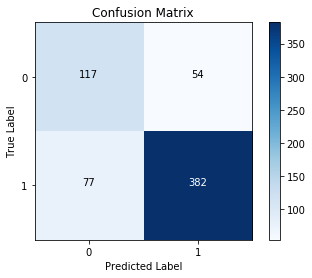

In [121]:
show_cf(y_test, y_pred)

In [24]:
extratree = ExtraTreesClassifier(bootstrap=False, criterion='entropy', max_features=0.15000000000000002, min_samples_leaf=3, min_samples_split=8, n_estimators=100)
extratree.fit(X_resampled, y_resampled) 
y_pred = extratree.predict(X_test)
extratree.score(X_test, y_test)

0.8

In [58]:
print_metrics(y_test, y_pred)

NameError: name 'print_metrics' is not defined

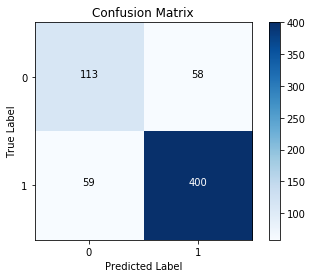

In [163]:
show_cf(y_test, y_pred)

Feature ranking:
1. feature 53 (0.036359)
2. feature 52 (0.031528)
3. feature 10 (0.031085)
4. feature 11 (0.030433)
5. feature 31 (0.024774)
6. feature 18 (0.024344)
7. feature 58 (0.023766)
8. feature 0 (0.023121)
9. feature 32 (0.022391)
10. feature 57 (0.022259)
11. feature 41 (0.022183)
12. feature 56 (0.020729)
13. feature 21 (0.020315)
14. feature 12 (0.020028)
15. feature 27 (0.020022)
16. feature 16 (0.019526)
17. feature 46 (0.018949)
18. feature 33 (0.018688)
19. feature 17 (0.018384)
20. feature 23 (0.018275)
21. feature 9 (0.017542)
22. feature 42 (0.017414)
23. feature 1 (0.017090)
24. feature 35 (0.016848)
25. feature 15 (0.016355)
26. feature 43 (0.016045)
27. feature 60 (0.015911)
28. feature 34 (0.015862)
29. feature 4 (0.015707)
30. feature 7 (0.015555)
31. feature 13 (0.015272)
32. feature 24 (0.015078)
33. feature 5 (0.014871)
34. feature 2 (0.014574)
35. feature 40 (0.014309)
36. feature 25 (0.014179)
37. feature 19 (0.013783)
38. feature 59 (0.012704)
39. feature

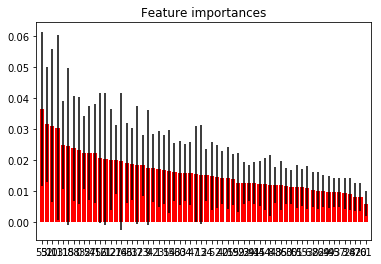

In [238]:
importances = extratree.feature_importances_
std = np.std([tree.feature_importances_ for tree in extratree.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

## PCA

Text(0, 0.5, 'Explained Variance')

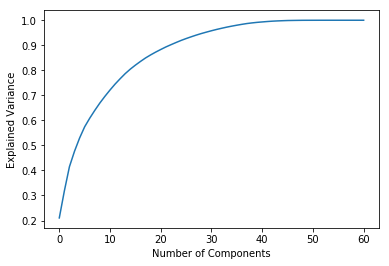

In [180]:
pca = PCA(61)
pca_full = pca.fit(X_resampled)

plt.plot(np.cumsum(pca_full.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance')

In [182]:
pca_1 = PCA(n_components=20)
pca_2 = PCA(n_components=40)
pca_3 = PCA(n_components=60)

principalComponents = pca_1.fit_transform(X)
principalComponents = pca_2.fit_transform(X)
principalComponents = pca_3.fit_transform(X)

print(np.sum(pca_1.explained_variance_ratio_))
print(np.sum(pca_2.explained_variance_ratio_))
print(np.sum(pca_3.explained_variance_ratio_))

pca = PCA(n_components=61)
principalComponents = pca.fit_transform(X)
print(np.sum(pca.explained_variance_ratio_))

0.8663401251147058
0.9908715547124194
1.0
1.0


In [205]:
pca = PCA(50)
pca_full = pca.fit(X)
X_train_pca = pca.transform(X_resampled)
X_test_pca = pca.transform(X_test)

In [206]:
X_train_pca.shape

(2748, 50)

In [207]:
X_test_pca.shape

(630, 50)

In [208]:
extratree = ExtraTreesClassifier(bootstrap=False, criterion='entropy', max_features=0.15000000000000002, min_samples_leaf=3, min_samples_split=8, n_estimators=100)
extratree.fit(X_train_pca, y_resampled) 
y_pred = extratree.predict(X_test_pca)
extratree.score(X_test_pca, y_test)

0.7952380952380952

## Linear Regression for Number of Prescription Drugs 

In [155]:
lin_reg_data = model_data

In [156]:
lin_reg_data.columns

Index(['rate_avg', 'prescriptions_per_100', 'uninsured_2015', 'uninsured_2016',
       'population_estimate', 'median age',
       'Employment/Population Ratio; Estimate; AGE - 16 to 19 years',
       'Employment/Population Ratio; Estimate; AGE - 65 to 74 years',
       'Employment/Population Ratio; Estimate; AGE - 75 years and over',
       'Percent households receiving food stamps/SNAP; Estimate; Households',
       'percent_in_labor_force', 'percent_in_civilian_labor_force',
       'percent_in_civilian_labor_force_employed',
       'percent_in_civilian_labor_force_unemployed',
       'percent_in_labor_force_armed_forces', 'percent_not_in_labor_force',
       'percent_income_below_poverty_line', 'Total Health Spending',
       'SMHA Expenditures Per Capita', 'share_medical_debt_collections',
       'median_medical_debt_collections', 'share_student_loan_debt',
       'share_with_auto_debt', 'share_with_auto_or_retail_debt',
       'auto_retail_debt_delinquency_rate', 'Medicinal', 'Dec

In [157]:
inpatient_stays = pd.read_csv('data/inpatient_stays.csv')

In [158]:
inpatient_stays.head()

,STATEFP,STATE,STATEABBREVIATION,YEAR,INDICATOR,VALUE
0,1,Alabama,AL,2005,op_rel_inpat,NaN
1,1,Alabama,AL,2006,op_rel_inpat,NaN
2,1,Alabama,AL,2007,op_rel_inpat,NaN
3,1,Alabama,AL,2008,op_rel_inpat,NaN
4,1,Alabama,AL,2009,op_rel_inpat,NaN


In [159]:
inpatient_stays.shape

(583, 6)

In [160]:
inpatient_stays.isna().sum()

STATEFP                0
STATE                  0
STATEABBREVIATION      0
YEAR                   0
INDICATOR              0
VALUE                108
dtype: int64

In [161]:
inpatient_stays = inpatient_stays[inpatient_stays['YEAR'] == 2015]

In [162]:
inpatient_stays['VALUE'] = inpatient_stays['VALUE'].fillna(inpatient_stays['VALUE'].mean())

In [137]:
X = lin_reg_data.drop(['prescriptions_per_100'], axis=1)
y = lin_reg_data.prescriptions_per_100

In [138]:
len(X)

2517

In [139]:
len(y)

2517

In [140]:
X = pd.get_dummies(X)
cols = X.columns.tolist()
scaler = preprocessing.StandardScaler()
X = scaler.fit_transform(X)
X = pd.DataFrame(X, columns=cols)

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [141]:
len(X)

2517

In [142]:
len(y)

2517

In [143]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123, test_size = 0.2)

In [144]:
len(X_train)

2013

In [145]:
len(y_train)

2013

In [146]:
lm = LinearRegression()
model = lm.fit(X_train, y_train)
y_pred = lm.predict(X_test)

In [154]:
print(metrics.mean_absolute_error(y_test, y_pred))
print(metrics.mean_squared_error(y_test, y_pred))
print(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print(lm.score(X_test, y_test))

25.70847799047843
1185.8690184511338
34.436448981437294
0.2888806424412095


In [148]:
np.sqrt(metrics.mean_squared_error(y_test, y_pred))/y.std()

0.8640114224341067

In [149]:
lm.r2_score

AttributeError: 'LinearRegression' object has no attribute 'r2_score'

In [43]:
poly = preprocessing.PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
features_64_train = pd.DataFrame(poly.fit_transform(X_train), columns=poly.get_feature_names(X_train.columns))
features_64_train.head()

,rate_avg,uninsured_2015,uninsured_2016,population_estimate,median age,Employment/Population Ratio; Estimate; AGE - 16 to 19 years,Employment/Population Ratio; Estimate; AGE - 20 to 24 years,Employment/Population Ratio; Estimate; AGE - 25 to 29 years,Employment/Population Ratio; Estimate; AGE - 30 to 34 years,Employment/Population Ratio; Estimate; AGE - 35 to 44 years,...,state_Wisconsin^2,state_Wisconsin state_Wyoming,state_Wisconsin policy_No,state_Wisconsin policy_Yes,state_Wyoming^2,state_Wyoming policy_No,state_Wyoming policy_Yes,policy_No^2,policy_No policy_Yes,policy_Yes^2
0,-1.637017,-0.375590,-0.503527,-0.287314,1.251821,-1.326109,-2.148085,1.570845,0.051476,0.737965,...,0.029027,0.016361,0.100632,-0.100632,0.009222,0.056722,-0.056722,0.348875,-0.348875,0.348875
1,-1.637017,1.582303,1.714199,-0.278651,0.509450,-1.865178,-1.224529,-0.347637,0.116794,-0.859936,...,0.029027,0.016361,-0.288447,0.288447,0.009222,-0.162585,0.162585,2.866359,-2.866359,2.866359
2,0.610867,-0.412186,-0.557181,-0.055659,-0.156781,0.496460,0.907909,0.220802,0.786303,0.728281,...,0.029027,0.016361,0.100632,-0.100632,0.009222,0.056722,-0.056722,0.348875,-0.348875,0.348875
3,-1.637017,1.399322,1.410156,-0.261224,-0.803977,-0.051167,0.014388,-0.213422,-0.960951,-0.656566,...,0.029027,0.016361,0.100632,-0.100632,0.009222,0.056722,-0.056722,0.348875,-0.348875,0.348875
4,-1.637017,2.625292,3.001910,-0.254951,0.756907,-0.838379,-1.314632,-0.663436,-2.806183,-3.222892,...,0.029027,0.016361,0.100632,-0.100632,0.009222,0.056722,-0.056722,0.348875,-0.348875,0.348875


In [44]:
features_64_test = pd.DataFrame(poly.fit_transform(X_test), columns=poly.get_feature_names(X_test.columns))
features_64_test.head()

,rate_avg,uninsured_2015,uninsured_2016,population_estimate,median age,Employment/Population Ratio; Estimate; AGE - 16 to 19 years,Employment/Population Ratio; Estimate; AGE - 20 to 24 years,Employment/Population Ratio; Estimate; AGE - 25 to 29 years,Employment/Population Ratio; Estimate; AGE - 30 to 34 years,Employment/Population Ratio; Estimate; AGE - 35 to 44 years,...,state_Wisconsin^2,state_Wisconsin state_Wyoming,state_Wisconsin policy_No,state_Wisconsin policy_Yes,state_Wyoming^2,state_Wyoming policy_No,state_Wyoming policy_Yes,policy_No^2,policy_No policy_Yes,policy_Yes^2
0,-1.637017,-0.393888,-0.539296,-0.069991,-0.270992,-0.941059,-0.608825,-1.405565,-1.132411,-1.237621,...,0.029027,0.016361,0.100632,-0.100632,0.009222,0.056722,-0.056722,0.348875,-0.348875,0.348875
1,-1.637017,-0.210908,-0.002750,-0.268455,-0.042570,-0.085393,-1.059340,-1.847684,0.320913,0.650807,...,0.029027,0.016361,0.100632,-0.100632,0.009222,0.056722,-0.056722,0.348875,-0.348875,0.348875
2,-1.637017,0.063563,0.086675,-0.269546,1.994193,0.128523,0.217120,-1.342405,-0.707844,-0.937410,...,0.029027,0.016361,0.100632,-0.100632,0.009222,0.056722,-0.056722,0.348875,-0.348875,0.348875
3,0.610867,1.033361,1.088228,-0.267446,1.537349,1.258002,-0.270939,-0.584486,-0.275113,-0.152986,...,0.029027,0.016361,0.100632,-0.100632,0.009222,0.056722,-0.056722,0.348875,-0.348875,0.348875
4,0.610867,-0.229206,-0.521411,-0.180979,-0.290027,-0.384876,1.073098,0.276067,-0.332266,0.079436,...,0.029027,0.016361,0.100632,-0.100632,0.009222,0.056722,-0.056722,0.348875,-0.348875,0.348875


In [43]:
y.mean()

75.32864410329029

In [44]:
np.sqrt(metrics.mean_squared_error(y_test, y_pred))/y.std()

0.8623407136722433

In [45]:
from sklearn.feature_selection import VarianceThreshold

In [46]:
thresholder = VarianceThreshold(threshold=.5)

def variance_threshold_selector(data, threshold=0.5):
    selector = VarianceThreshold(threshold)
    selector.fit(data)
    return data[data.columns[selector.get_support(indices=True)]]

In [47]:
X_train = variance_threshold_selector(features_64_train)

In [ ]:
import seaborn as sns

sns.set(style="white")

# Compute the correlation matrix
corr = X_train.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [77]:
# Create correlation matrix
corr_matrix = X_train.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

In [78]:
to_drop

[]

In [79]:
# X_train.drop(columns=to_drop, inplace=True)

In [80]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression, mutual_info_regression

In [81]:
def information_selector(X, y, scoring, k=5):
    selector = SelectKBest(score_func=scoring, k=k)
    selector.fit(X, y)
    return X[X.columns[selector.get_support(indices=True)]]

In [82]:
test = SelectKBest(score_func=mutual_info_regression, k=100)
fit = test.fit(X_train, y_train)

ValueError: k should be >=0, <= n_features = 30; got 100. Use k='all' to return all features.

In [71]:
X_train = information_selector(X_train, y_train, mutual_info_regression, k=100)

ValueError: k should be >=0, <= n_features = 30; got 100. Use k='all' to return all features.

In [72]:
# fit a model
lm = linear_model.LinearRegression()
model = lm.fit(X_train, y_train)

In [64]:
features_selected_test = features_64_test[X_train.columns]
y_pred = lm.predict(features_selected_test)

In [65]:
print(metrics.mean_absolute_error(y_test, y_pred))
print(metrics.mean_squared_error(y_test, y_pred))
print(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

30.6435182895187
1504.4535507769888
38.7872859423934


In [639]:
from sklearn.feature_selection import RFE

In [640]:

rfe = RFE(lm, n_features_to_select=10)
rfe.fit(X_train,y_train)

RFE(estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False),
  n_features_to_select=10, step=1, verbose=0)

In [641]:
def ranking(ranks, names, order=1):

    ranks = map(lambda x: round(x,2), ranks)
    return list(sorted(zip(ranks, names),reverse=True))

In [642]:

rankings = ranking(np.abs(lm.coef_), features_selected_train.columns)

In [651]:
rankings[:30]

[(27.46, 'percent_not_in_labor_force'),
 (25.44, 'percent_in_civilian_labor_force_unemployed'),
 (16.5, 'percent_in_labor_force_armed_forces'),
 (13.06, 'percent_income_below_poverty_line'),
 (12.65, 'uninsured_2015'),
 (10.57, 'share_with_auto_or_retail_debt'),
 (7.84, 'Employment/Population Ratio; Estimate; AGE - 75 years and over'),
 (7.62, 'Employment/Population Ratio; Estimate; AGE - 20 to 24 years'),
 (7.55, 'Employment/Population Ratio; Estimate; AGE - 16 to 19 years'),
 (6.43, 'median age'),
 (5.09, 'rate_avg'),
 (4.72, 'Employment/Population Ratio; Estimate; AGE - 35 to 44 years'),
 (4.58, 'share_medical_debt_collections'),
 (4.06, 'Employment/Population Ratio; Estimate; AGE - 30 to 34 years'),
 (3.9, 'Employment/Population Ratio; Estimate; AGE - 25 to 29 years'),
 (3.57, 'share_with_auto_debt'),
 (3.27, 'Employment/Population Ratio; Estimate; AGE - 55 to 59 years'),
 (2.53, 'percent_in_civilian_labor_force'),
 (2.22, 'Total Health Spending'),
 (1.97, 'SMHA Expenditures Per Ca